In [ ]:
# This notebook shows how to use the plot_misclass.py file
# The beginning of the notebook is just training the model through a few epochs, skip to the bottom for demonstration

In [2]:
# External package imports
import tensorflow as tf
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from data_loader import initialize_dataset

import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/midterm_project/cassava-leaf-disease-classification/train_tfrecords2"

In [5]:
# Get a list of the training record files
tfrecord_files = glob.glob(os.path.join(path, "*.tfrec"))

# Define the number of files for training, 70% of files
n_file_train = int(0.7 * len(tfrecord_files))

# Split the record files into 70% training and 30% validation
tfrecord_files_train = tfrecord_files[:n_file_train]
tfrecord_files_valid = tfrecord_files[n_file_train:]

In [6]:
# Define batch size
BATCH_SIZE = 32

# Define processed image size
HEIGHT = 258
WIDTH = HEIGHT
#IMG_SIZE = (HEIGHT, WIDTH)

In [7]:
# Initialize the training data loader, with random flipping and rotations
dataset_train = initialize_dataset(tfrecord_files_train, batch_size=BATCH_SIZE, img_size=(HEIGHT, WIDTH), flip=True, rot=(-1, 1))

# Initialize the validation loader, with no flipping or rotations
dataset_valid = initialize_dataset(tfrecord_files_valid, img_size=(HEIGHT, WIDTH))

In [8]:
initial_learning_rate = 0.00004
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9)
opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

def build_EffNet():
    base_model = tf.keras.applications.EfficientNetB1(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(HEIGHT, WIDTH, 3),
        pooling=None,
      )
    #base_model.trainable = False
    x = base_model.output
    model = Flatten()(x)
    model = Dropout(rate=0.25)(model)
    predictions = Dense(5, activation = "softmax")(model)
    model = Model(inputs = base_model.input, outputs = predictions)
    return model
EffNet = build_EffNet()
EffNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

27025408/27018416 [==============================] - 0s 0us/step


In [9]:
train_hist = EffNet.fit(
    x=dataset_train,
    epochs=2,
    validation_data=dataset_valid
)

Epoch 1/2
460/460 [==============================] - 492s 959ms/step - loss: 1.1776 - accuracy: 0.6099 - val_loss: 0.7998 - val_accuracy: 0.7339
Epoch 2/2
460/460 [==============================] - 433s 941ms/step - loss: 0.7928 - accuracy: 0.7315 - val_loss: 0.6881 - val_accuracy: 0.7640


In [9]:
#model_path = '/content/drive/MyDrive/midterm_project'
#EffNet.save(model_path)

In [11]:
#EffNet = keras.models.load_model(model_path)

In [12]:
from plot_misclass import investigate_misclass

# Provide the investigate_misclass class with a model and a data loader
test = investigate_misclass(EffNet, dataset_valid)

# find the first 100 misclassifications and save in "test" object
test.find_misclass(100)

Done
100 misclassified images saved out of 402 images scanned


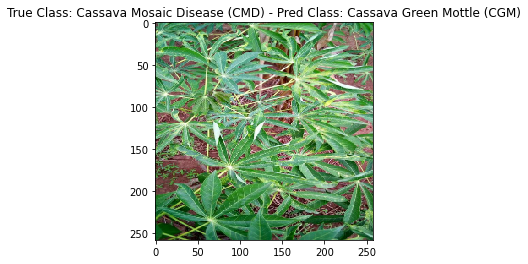

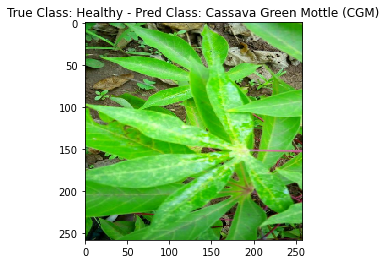

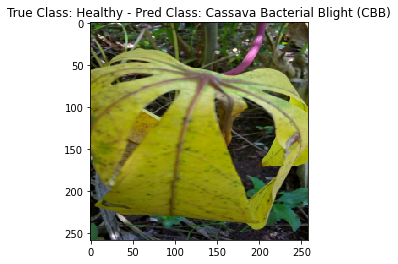

In [13]:
# iterate through images 1 - 3 and print them all (indexing starts at 0)
test.print_misclass(0,3)

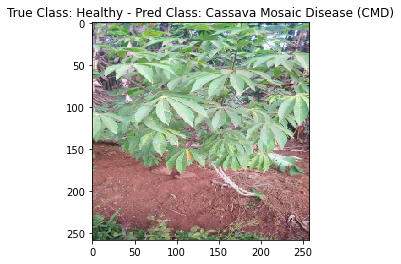

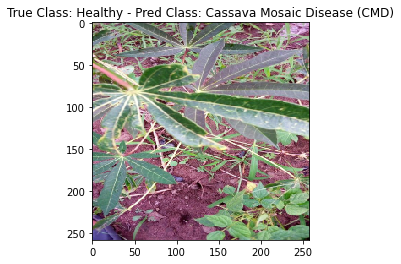

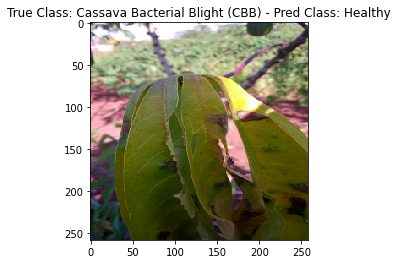

In [14]:
# iterate through images 98 - 100 and print them all
test.print_misclass(97,100)

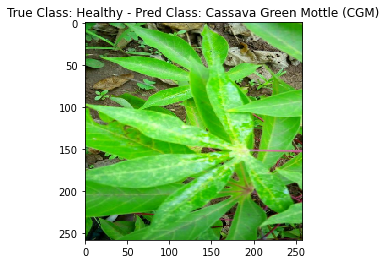

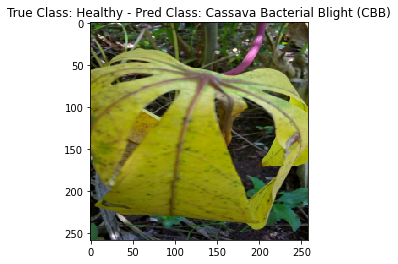

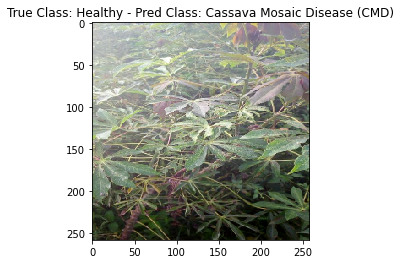

In [15]:
# iterate through imges 0 - 20 and print only the images with true label 4 (health)
test.print_misclass(0,20,true=4)

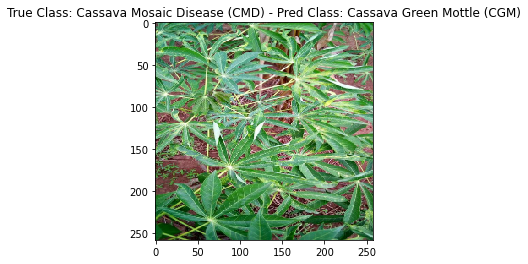

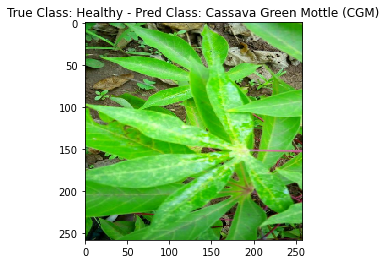

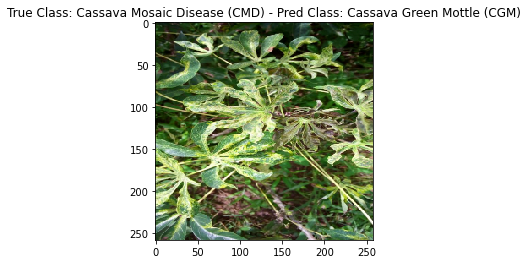

In [16]:
# iterate through imges 0 - 20 and print only the images that were predicted as class 2 (Cassava Green Mottle (CGM))
test.print_misclass(0,20,pred=2)

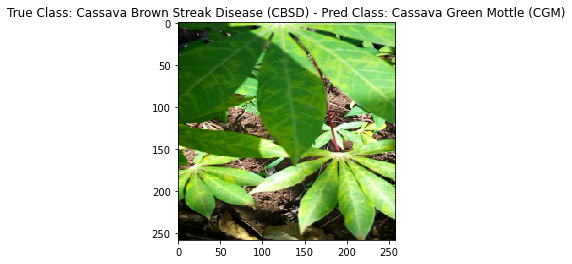

In [18]:
# iterate through images 0 - 100 and print only the images with true label 1 (Cassava Brown Streak Disease (CBSD)) 
# that were predicted as class 2 (Cassava Green Mottle (CGM))
test.print_misclass(0,100,true=1,pred=2)

In [19]:
# test.classes contains a dictionary matching class numbers to labels
test.classes

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}